## Importeer bibliotheken

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import json

## Laad de geveltekening in
De afbeelding wordt geladen met alpha-kanaal als dat beschikbaar is. De afmetingen worden weergegeven

In [2]:
# === Afbeelding inladen: half_vrijstaand_type_e ===
img = cv2.imread(r"Data_nest_uitgesneden\half_vrijstaand_type_e (1).png")
# img = cv2.imread(r"Data_nest_uitgesneden\halfvrijestaande (4).png")  # Alternatieve testafbeelding

## Toon de originele geveltekening

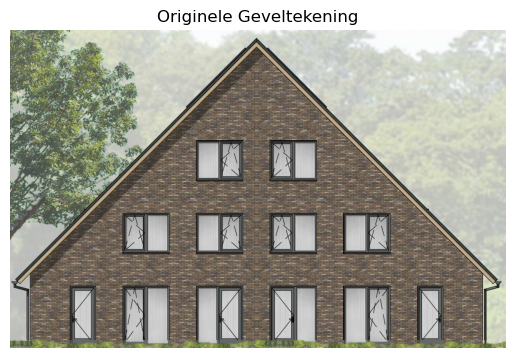

In [3]:
# === Converteer afbeelding naar RGB voor correcte weergave met matplotlib ===
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === Toon de originele geveltekening ===
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis("off")
plt.show()

## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

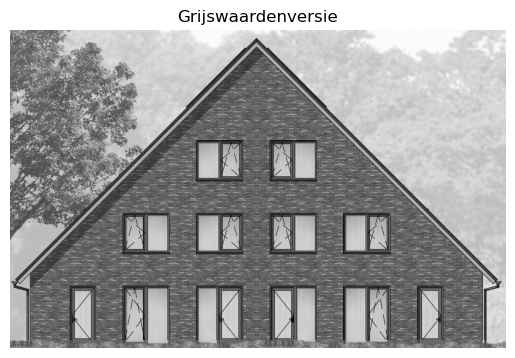

In [4]:
# === Converteer afbeelding naar grijswaarden ===
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# === Toon grijswaardenafbeelding ===
plt.imshow(img_gray, cmap="gray")
plt.title("Grijswaardenversie")
plt.axis("off")
plt.show()

## Randdetectie met Canny

We passen de Canny-algoritme toe op de grijswaardenversie van de afbeelding om de randen te detecteren.  
Dit helpt bij het isoleren van structuren zoals muren, ramen en deuren.  

De gekozen drempelwaarden `(50, 150)` bepalen de gevoeligheid van de detectie:

- Waarden onder `50` worden als geen rand beschouwd.
- Waarden boven `150` worden altijd als rand geaccepteerd.
- Waarden daartussen worden alleen als rand gezien als ze verbonden zijn met sterke randen.

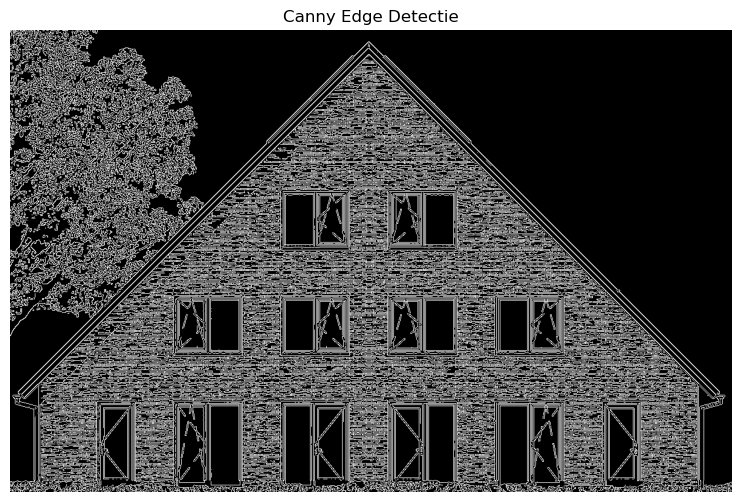

In [5]:
# === Pas Canny edge-detectie toe ===
edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)

# === Toon het resultaat van de edge-detectie ===
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detectie")
plt.axis("off")
plt.show()

## Het resultaat

De drempelwaarden van **50 en 150** blijken in de praktijk het beste resultaat te geven.  
We hebben deze waarden getest op meerdere foto's, en ze leveren consistente detectie op voor zowel ramen als deuren.

Wanneer we andere drempelwaarden gebruiken, zien we dat het resultaat soms goed is voor één afbeelding, maar leidt tot fouten bij andere.  
Bijvoorbeeld: bij een te lage drempel worden randen van ramen niet goed gedetecteerd, terwijl bij een te hoge drempel kleinere details zoals deuren verloren gaan.

Daarom kiezen we deze waarden als standaard, omdat ze het meest betrouwbaar zijn over verschillende gevelafbeeldingen.


## Contourdetectie met `cv2.findContours`

### Canny Edge Detectie

In deze cel wordt de Canny edge detectie toegepast op de grijswaardenversie van de afbeelding.  
De functie `cv2.findContours` wordt vervolgens gebruikt om de randen (contouren) van objecten te vinden in een binaire afbeelding, bijvoorbeeld als resultaat van Canny-edge detectie.  
Een **contour** is een reeks coördinaten die gezamenlijk de omtrek van een object vormen.

---

### Reden voor het gebruik van `RETR_TREE`

Het contour-ophaalmodel `cv2.RETR_TREE` haalt niet alleen alle contouren op, maar bewaart ook de **hiërarchische relatie** tussen objecten.  
Deze hiërarchie is essentieel bij technische tekeningen, zoals geveltekeningen, waarin structuren elkaar kunnen bevatten:

- Hoofdstructuur (zoals een gebouw) wordt als **parent** herkend  
- Interne elementen (zoals ramen en deuren) als **children**  
- Substructuren (zoals glas in een raam) als **kind van een kind**

Op deze manier ontstaat een gestructureerd inzicht dat noodzakelijk is voor een correcte interpretatie van complexe bouwkundige tekeningen.

---

### Vergelijking met andere modi

| Mode            | Aanbevolen | Toelichting                                                                 |
|-----------------|------------|------------------------------------------------------------------------------|
| `RETR_EXTERNAL` | Nee     | Detecteert alleen buitencontour; interne structuren zoals ramen ontbreken   |
| `RETR_LIST`     | Nee     | Levert een lijst van contouren zonder hiërarchie; relatie tussen objecten ontbreekt |
| `RETR_CCOMP`    | Nee     | Slechts twee hiërarchische niveaus; onvoldoende voor gedetailleerde tekeningen |
| `RETR_TREE`     | Ja      | Volledige hiërarchie; geschikt voor het herkennen van complexe objectstructuren |

---

## Contourdetectie en Visualisatie van Objecten

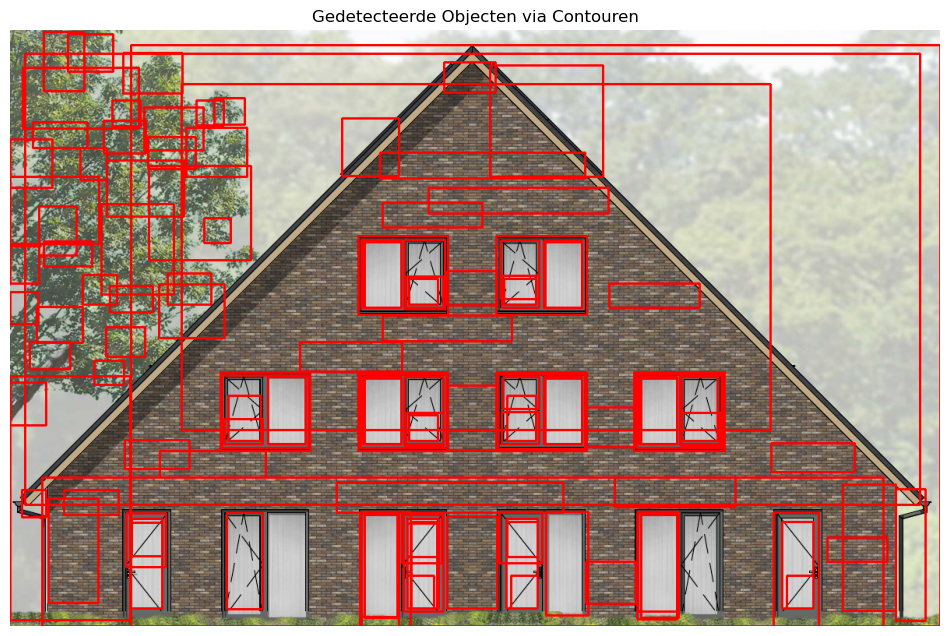

In [6]:
# === Zoek contouren in het edge-detectiebeeld ===
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# === Kopie van de originele afbeelding voor visualisatie ===
img_contours = img_rgb.copy()

# === Teken bounding boxes rond voldoende grote contouren ===
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30 and h > 30:
        cv2.rectangle(img_contours, (x, y), (x + w, y + h), (255, 0, 0), 2)

# === Plot resultaat ===
plt.figure(figsize=(12, 8))
plt.imshow(img_contours)
plt.title("Gedetecteerde Objecten via Contouren")
plt.axis("off")
plt.show()

 ### In deze stap worden contouren gezocht in het edge-detectiebeeld. Daarna worden de gevonden contouren gefilterd op grootte om ruis te vermijden.


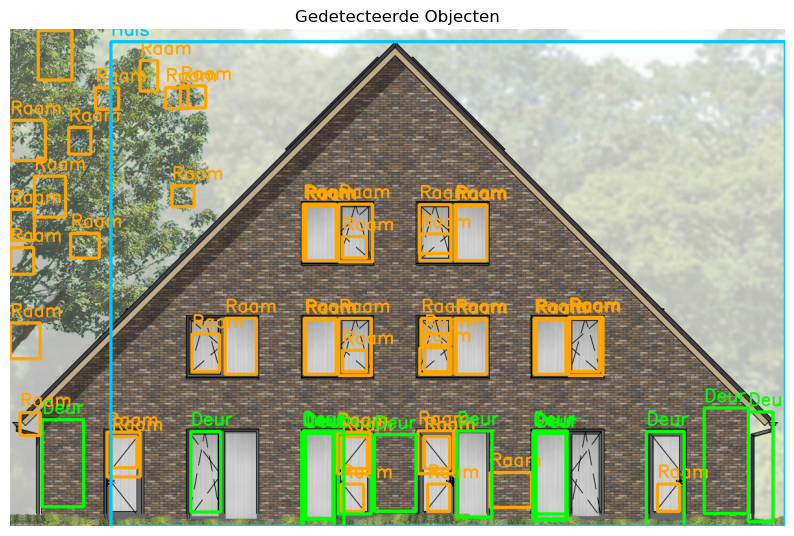

In [7]:
# === Vind contouren in het edge-beeld ===
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# === Maak een kopie van de originele afbeelding ===
output_img = img_rgb.copy()

# === Bepaal grootste contour op basis van oppervlak ===
largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])
largest_area = cv2.boundingRect(largest_cnt)[2] * cv2.boundingRect(largest_cnt)[3]

# === Drempels voor classificatie (oppervlakte) ===
min_area_door = 5000
max_area_door = 20000
min_area_window = 1000
max_area_window = 5000

# === Aspect ratio grenzen (breedte / hoogte) ===
door_aspect_min = 0.0
door_aspect_max = 0.7
window_aspect_min = 0.5
window_aspect_max = 1.2

detected_objects = []

# === Classificeer contouren ===
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0

    if np.array_equal(cnt, largest_cnt):
        label = "Huis"
        color = (0, 200, 255)
    elif min_area_door < area < max_area_door and door_aspect_min < aspect_ratio < door_aspect_max:
        label = "Deur"
        color = (0, 255, 0)
    elif min_area_window < area < max_area_window and window_aspect_min < aspect_ratio < window_aspect_max:
        label = "Raam"
        color = (255, 165, 0)
    else:
        continue

    cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# === Toon resultaat ===
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten")
plt.axis("off")
plt.show()

## Conclusie: Contourdetectie op gevelafbeelding

De contourdetectie met `cv2.findContours` (in combinatie met `RETR_TREE`) resulteert in een gedetailleerde identificatie van objectranden binnen de geveltekening.  Er is ervoor gekozen om alleen contouren met een bepaalde minimale breedte en hoogte te behouden, gebaseerd op de beste resultaten die naar voren kwamen na meerdere tests op verschillende afbeeldingen. Dit helpt om ruis te verminderen.

### Observaties

- **Hoofdlijnen van ramen en deuren worden correct herkend**, inclusief de onderliggende structuur.
- **Meerdere contouren op één object**:
  - Sommige ramen en deuren bevatten meerdere rechthoeken, veroorzaakt door lijndetails zoals raamkozijnen of glasverdelingen.
- **Contouren in achtergrondobjecten** (zoals de boom links) worden eveneens meegenomen.
- **Verbindingen tussen muur en dak** zorgen voor grotere contouren die meerdere elementen tegelijk omhullen.
- **Geen semantisch onderscheid**: het algoritme herkent vormen, maar weet niet of het om een raam, deur of boomtak gaat.

### Algemene beoordeling

De `RETR_TREE`-structuur is effectief voor het reconstrueren van hiërarchieën in bouwkundige tekeningen. Echter, voor nauwkeurige objectclassificatie is aanvullende filtering of contextuele interpretatie nodig.


## Gevelobjectdetectie op meerdere afbeeldingen

In deze notebook voeren we een eenvoudige objectdetectie uit op gevelafbeeldingen. De pipeline herkent:
- het grootste object als **"Huis"**,
- objecten van middelgroot formaat als **"Deur"**,
- kleinere rechthoeken als **"Raam"**.

De resultaten worden per afbeelding getoond én automatisch opgeslagen in een lokale folder:
`Nest-Project/Old_school_AI_test_foto's\model_1`.


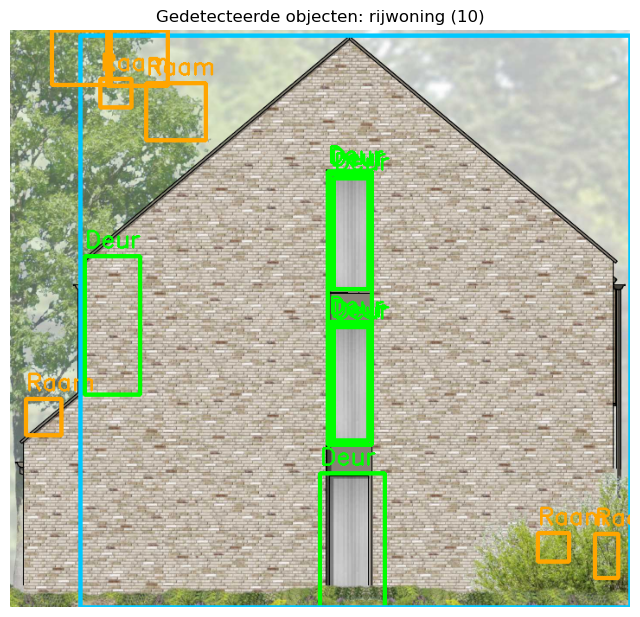

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_resultaat_rijwoning (10).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_rijwoning (10).json


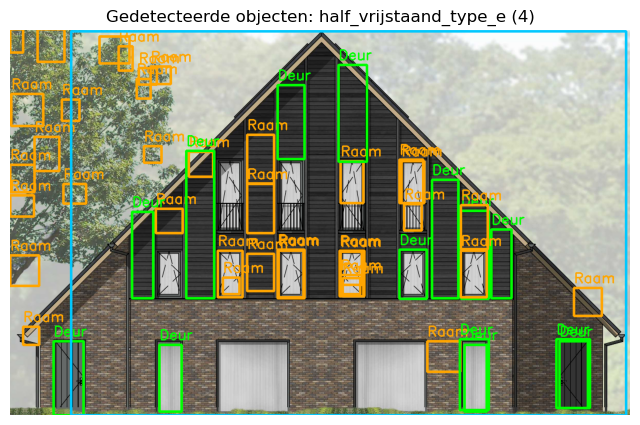

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_resultaat_half_vrijstaand_type_e (4).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_half_vrijstaand_type_e (4).json


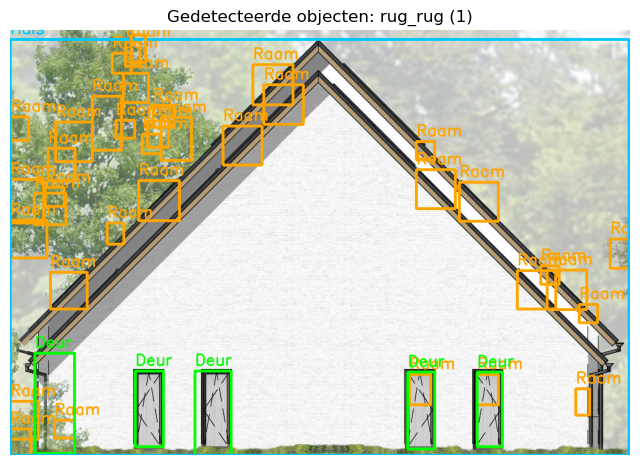

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_resultaat_rug_rug (1).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_rug_rug (1).json


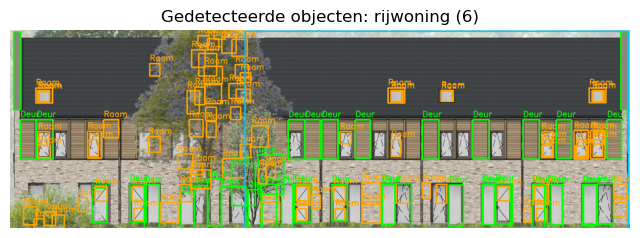

Opgeslagen: .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_resultaat_rijwoning (6).jpg en .\Old_school_AI_test_foto's_na_detecteren\model_1\detectie_rijwoning (6).json


In [8]:
# === Opslagpad configureren ===
opslagmap = os.path.join(".", "Old_school_AI_test_foto's_na_detecteren", "model_1") 
os.makedirs(opslagmap, exist_ok=True)

# === Invoerpaden voor afbeeldingen ===
afbeeldingspaden = [
    os.path.join("data_nest_uitgesneden", "rijwoning (10).png"),
    os.path.join("data_nest_uitgesneden", "half_vrijstaand_type_e (4).png"),
    os.path.join("data_nest_uitgesneden", "rug_rug (1).png"),
    os.path.join("data_nest_uitgesneden", "rijwoning (6).png")
]

# === Classificatieparameters ===
min_oppervlakte_deur = 5000
max_oppervlakte_deur = 20000
min_oppervlakte_raam = 1000
max_oppervlakte_raam = 5000

deur_aspect_min = 0.0
deur_aspect_max = 0.7
raam_aspect_min = 0.5
raam_aspect_max = 1.2

# === Verwerking per afbeelding ===
for pad in afbeeldingspaden:
    bestandsnaam = os.path.splitext(os.path.basename(pad))[0]
    afbeelding = cv2.imread(pad)

    if afbeelding is None:
        print(f"Fout bij inladen afbeelding: {pad}")
        continue

    afbeelding_rgb = cv2.cvtColor(afbeelding, cv2.COLOR_BGR2RGB)
    afbeelding_grijs = cv2.cvtColor(afbeelding, cv2.COLOR_BGR2GRAY)

    # === Randdetectie ===
    randen = cv2.Canny(afbeelding_grijs, 50, 150)

    # === Zoek contouren ===
    contouren, _ = cv2.findContours(randen, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    uitvoer_afbeelding = afbeelding_rgb.copy()
    gedetecteerde_objecten = []

    if not contouren:
        print(f"Geen contouren gevonden in afbeelding: {bestandsnaam}")
        continue

    grootste_contour = max(contouren, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

    # === Classificatie van contouren ===
    for contour in contouren:
        x, y, w, h = cv2.boundingRect(contour)
        oppervlakte = w * h
        aspectverhouding = w / h if h != 0 else 0

        if np.array_equal(contour, grootste_contour):
            label = "Huis"
            kleur = (0, 200, 255)
        elif min_oppervlakte_deur < oppervlakte < max_oppervlakte_deur and deur_aspect_min < aspectverhouding < deur_aspect_max:
            label = "Deur"
            kleur = (0, 255, 0)
        elif min_oppervlakte_raam < oppervlakte < max_oppervlakte_raam and raam_aspect_min < aspectverhouding < raam_aspect_max:
            label = "Raam"
            kleur = (255, 165, 0)
        else:
            continue

        cv2.rectangle(uitvoer_afbeelding, (x, y), (x + w, y + h), kleur, 3)
        cv2.putText(uitvoer_afbeelding, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, kleur, 2)

        gedetecteerde_objecten.append({
            "label": label,
            "bounding_box": [int(x), int(y), int(w), int(h)],
            "aspectverhouding": round(aspectverhouding, 2)
        })

    # === Resultaat tonen ===
    plt.figure(figsize=(8, 8))
    plt.imshow(uitvoer_afbeelding)
    plt.title(f"Gedetecteerde objecten: {bestandsnaam}")
    plt.axis("off")
    plt.show()

    # === Resultaten opslaan ===
    uitvoerpad_afbeelding = os.path.join(opslagmap, f"detectie_resultaat_{bestandsnaam}.jpg")
    uitvoerpad_json = os.path.join(opslagmap, f"detectie_{bestandsnaam}.json")

    cv2.imwrite(uitvoerpad_afbeelding, cv2.cvtColor(uitvoer_afbeelding, cv2.COLOR_RGB2BGR))

    with open(uitvoerpad_json, "w") as bestand:
        json.dump(gedetecteerde_objecten, bestand, indent=2)

    print(f"Opgeslagen: {uitvoerpad_afbeelding} en {uitvoerpad_json}")

De laatste celcode is bedoeld voor het valideren van 4 geveltekeningen. Ze zijn opgeslagen in de juiste map om later te vergelijken met de juiste resultaat-/gelabelde geveltekening.